In [37]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [38]:
df = pd.read_csv('timeseries.csv')


In [39]:
df = df.dropna(subset=['time']) 
df['time'].tail(20)
# df['time'][78886]

96418                                        20201231:1007
96419                                        20201231:1107
96420                                        20201231:1207
96421                                        20201231:1307
96422                                        20201231:1407
96423                                        20201231:1507
96424                                        20201231:1607
96425                                        20201231:1707
96426                                        20201231:1807
96427                                        20201231:1907
96428                                        20201231:2007
96429                                        20201231:2107
96430                                        20201231:2207
96431                                        20201231:2307
96433    G(i): Global irradiance on the inclined plane ...
96434                           H_sun: Sun height (degree)
96435            T2m: 2-m air temperature (degree Celsiu

In [40]:
df = df[:96431:]
df_multi = df.iloc[:,1:5] # removing the time column 
df.tail(30)
print(df_multi.tail(10))
print(df_multi.dtypes)
# y = [x for x in df['Int'] if x == 0.0]
# print(y)b
# type(df_multi)


         G(i)  H_sun    T2m  WS10m
96421  486.98   24.3  28.01   3.72
96422  221.49   11.9  26.94   3.59
96423       0    0.0  24.97   2.55
96424       0    0.0  23.19   1.86
96425       0    0.0  20.98   1.45
96426       0    0.0  19.31   1.38
96427       0    0.0  17.90   1.45
96428       0    0.0  16.52   1.52
96429       0    0.0  15.39   1.59
96430       0    0.0  14.28   1.59
G(i)      object
H_sun    float64
T2m      float64
WS10m    float64
dtype: object


In [41]:
df_multi['G(i)'] = pd.to_numeric(df_multi['G(i)'], errors='coerce')
unique_types = df_multi['G(i)'].apply(type).unique()

print(unique_types)

[<class 'float'>]


In [42]:



correlation = df_multi['G(i)'].corr(df_multi['H_sun'])

print("Pearson Correlation Coefficient:", correlation)

Pearson Correlation Coefficient: 0.900361066319861


In [43]:
# Initialize the Min-Max Scaler

scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_data = scaler.fit_transform(df_multi)
print(scaled_data.shape)
print(scaled_data[1:10,:])

(96431, 4)
[[0.         0.         0.15526224 0.26194399]
 [0.         0.         0.13581105 0.29489292]
 [0.         0.         0.12782216 0.30642504]
 [0.07973716 0.03197405 0.12400139 0.31795717]
 [0.3747421  0.18153383 0.18339701 0.28336079]
 [0.59065139 0.32228916 0.32025009 0.28336079]
 [0.75219758 0.44775255 0.44911428 0.28336079]
 [0.8561645  0.54622335 0.51684613 0.27347611]
 [0.89670059 0.59905005 0.55331712 0.20428336]]


In [44]:
df_orignal_scaled = scaled_data
df_orignal = df_multi
df_scaled = scaled_data[:78888:]

In [45]:

print(df_scaled[0:5,:]) # this it the input
print(df_scaled[5,:]) # this is the output

[[0.         0.         0.17262939 0.26194399]
 [0.         0.         0.15526224 0.26194399]
 [0.         0.         0.13581105 0.29489292]
 [0.         0.         0.12782216 0.30642504]
 [0.07973716 0.03197405 0.12400139 0.31795717]]
[0.3747421  0.18153383 0.18339701 0.28336079]


In [46]:
def df_to_X_y(df_as_np, window_size=5):
#   df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size,:]]
    X.append(row)
    label = df_as_np[i+window_size,:]
    y.append(label)
  return np.array(X), np.array(y)

In [47]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
print(X1[1])
print("slfejlksdjlfkjdslkjfjlk")
print(y1[1])
X1.shape, y1.shape

[[0.         0.         0.15526224 0.26194399]
 [0.         0.         0.13581105 0.29489292]
 [0.         0.         0.12782216 0.30642504]
 [0.07973716 0.03197405 0.12400139 0.31795717]
 [0.3747421  0.18153383 0.18339701 0.28336079]]
slfejlksdjlfkjdslkjfjlk
[0.59065139 0.32228916 0.32025009 0.28336079]


((78883, 5, 4), (78883, 4))

In [48]:
X_train1, y_train1 = X1[:61367], y1[:61367]
X_val1, y_val1 = X1[61367:70127], y1[61367:70127] # 1 year for validation [61,367 , 70127]
X_test1, y_test1 = X1[70128:], y1[70128:] #  1 year testing [70,128 , 78887]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape


((61367, 5, 4), (61367, 4), (8760, 5, 4), (8760, 4), (8755, 5, 4), (8755, 4))

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 4)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(4, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17664     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 18,220
Trainable params: 18,220
Non-trainable params: 0
_________________________________________________________________


In [50]:
from tensorflow.keras.callbacks import EarlyStopping

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=6, verbose=1, mode='min')

In [52]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
# metrics , learning rate, loss  can be changed 
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [53]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1,early_stopping])

Epoch 1/100
1916/1918 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0969

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1918/1918 [==============================] - 22s 10ms/step - loss: 0.0094 - root_mean_squared_error: 0.0969 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 2/100
1912/1918 [============================>.] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0563

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1918/1918 [==============================] - 25s 13ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 3/100
1918/1918 [==============================] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0537

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1918/1918 [==============================] - 29s 15ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 4/100
1915/1918 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0524

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1918/1918 [==============================] - 40s 21ms/step - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 5/100
1918/1918 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0511

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1918/1918 [==============================] - 42s 21ms/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0543
Epoch 6/100
1917/1918 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0503

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1918/1918 [==============================] - 18s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0503 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0543
Epoch 7/100
1916/1918 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0496

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1918/1918 [==============================] - 18s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0539
Epoch 7: early stopping


In [54]:
from tensorflow.keras.models import load_model
model1 = load_model('model/')

In [55]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1.flatten()})
train_results.head(30)

1918/1918 [==============================] - 4s 2ms/step


,Train Predictions,Actuals
0,0.331650,0.374742
1,0.193645,0.181534
2,0.221881,0.183397
3,0.265768,0.283361
4,0.616869,0.590651
5,0.323691,0.322289
6,0.358107,0.320250
7,0.263564,0.283361
8,0.755652,0.752198
9,0.421018,0.447753


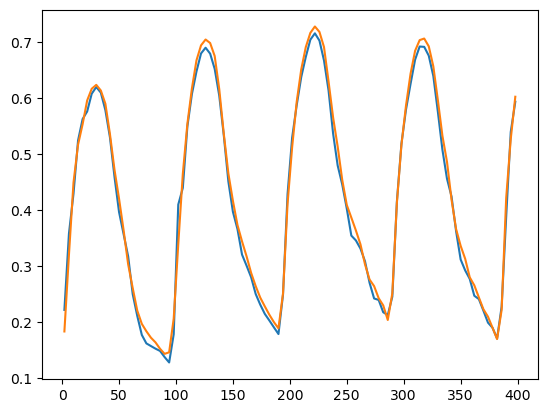

In [56]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][2:400:4])
plt.plot(train_results['Actuals'][2:400:4])

In [57]:

val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1.flatten()})
val_results

274/274 [==============================] - 0s 2ms/step


,Val Predictions,Actuals
0,0.086541,0.098332
1,0.020427,0.031974
2,0.130797,0.113234
3,0.489846,0.489292
4,0.400036,0.376303
...,...,...
35035,0.299433,0.294893
35036,0.053408,0.000000
35037,0.014016,0.000000
35038,0.139324,0.129559


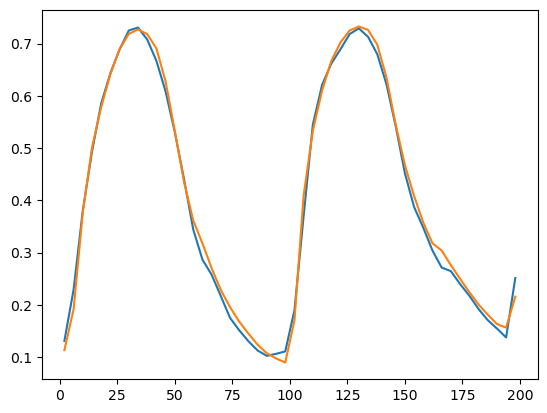

In [58]:
plt.plot(val_results['Val Predictions'][2:200:4])
plt.plot(val_results['Actuals'][2:200:4])

In [59]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1.flatten()})
test_results

274/274 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,0.164170,0.341072
1,0.108619,0.181534
2,0.149463,0.213963
3,0.240556,0.181219
4,0.588650,0.577188
...,...,...
35015,0.379400,0.375618
35016,-0.002856,0.000000
35017,-0.012658,0.000000
35018,0.265681,0.278569


In [60]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=1, end=400):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end:4])
  plt.plot(df['Actuals'][start:end:4])
  return df, mse(predictions, y)

274/274 [==============================] - 1s 2ms/step


(       Predictions   Actuals
 0         0.164170  0.341072
 1         0.108619  0.181534
 2         0.149463  0.213963
 3         0.240556  0.181219
 4         0.588650  0.577188
 ...            ...       ...
 35015     0.379400  0.375618
 35016    -0.002856  0.000000
 35017    -0.012658  0.000000
 35018     0.265681  0.278569
 35019     0.392206  0.385502
 
 [35020 rows x 2 columns],
 0.00222801074219492)

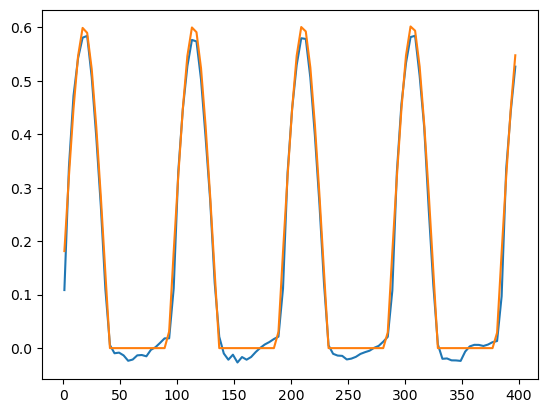

In [61]:
plot_predictions1(model1, X_test1, y_test1.flatten())

In [1]:
kkk = df_orignal_scaled[78885:78890,:]
print(type(kkk))
print(kkk.shape)
reshaped_array = np.reshape(kkk, (1, 5, 4))
print(reshaped_array)
predictions = model1.predict(reshaped_array)
print(predictions)
 
original= scaler.inverse_transform(predictions)
print(original)
# predictions
# inverse_data = np.zeros((len(predictions), scaler.shape[1]))

NameError: name 'df_orignal_scaled' is not defined

In [63]:

input = df_orignal_scaled[78888:78893,:]  # Initial input extracted from your original scaled DataFrame
output_scaled = []  
output_not_scaled = [] 

for i in range(24):
    # Reshape input for the model prediction
    reshaped_array = np.reshape(input, (1, 5, 4))
    scaled_prediction = model1.predict(reshaped_array)
    
    # Reshape the prediction to match the input shape if necessary
    # This example assumes the model returns a prediction with shape (1, 4)
    # Adjust the reshaping based on the actual shape of your model's output
    scaled_prediction_reshaped = np.reshape(scaled_prediction, (1, 4))
    input = np.reshape(input, (5, 4))  # Ensure input is in the correct shape before appending
    # Append the new prediction at the end of the input array
    input = np.vstack([input, scaled_prediction_reshaped])  # Stack vertically to add as a new row
    
    # Remove the oldest entry to maintain the sliding window of input data
    input = input[1:, :]  # Keep the last 5 entries, including the newly added prediction
 
    output_scaled.append(scaled_prediction)


# print(output_scaled)  # Remains empty, uncomment if needed
print(output_scaled)  # Print or process the predictions as 




1/1 [==============================] - 0s 28ms/step
[array([[0.20007545, 0.1308856 , 0.2402063 , 0.39320734]], dtype=float32), array([[0.45887744, 0.29970533, 0.38315594, 0.39697203]], dtype=float32), array([[0.654351 , 0.4323441, 0.5296263, 0.4836198]], dtype=float32), array([[0.777505  , 0.55283225, 0.61675936, 0.5392859 ]], dtype=float32), array([[0.836913  , 0.6366334 , 0.6805764 , 0.48869228]], dtype=float32), array([[0.82465047, 0.66447926, 0.7132198 , 0.3864921 ]], dtype=float32), array([[0.72954416, 0.60791516, 0.7237457 , 0.30311128]], dtype=float32), array([[0.56420743, 0.4889667 , 0.7206845 , 0.25684395]], dtype=float32), array([[0.35996562, 0.3411661 , 0.69896454, 0.23758847]], dtype=float32), array([[0.16545475, 0.17892551, 0.656984  , 0.23411395]], dtype=float32), array([[0.02807793, 0.03063732, 0.5949236 , 0.23891354]], dtype=float32), array([[-0.01971346, -0.03437542,  0.5147935 ,  0.24980584]],
      dtype=float32), array([[-0.05373052, -0.06314702,  0.41838497,  0.259

In [64]:
print("this is the real scaled output")
for i in output_scaled:
    original= scaler.inverse_transform(i)
    print(original)

this is the real scaled output
[[230.79503    11.298045   13.11554     2.3867686]]
[[529.3335     25.870564   17.231058    2.4096203]]
[[754.82007    37.319942   21.44794     2.9355721]]
[[896.8831     47.720478   23.956501    3.2734654]]
[[965.4126     54.954193   25.793793    2.9663622]]
[[951.2673    57.35785   26.733599   2.346007]]
[[841.55835    52.475235   27.036638    1.8398855]]
[[650.8358     42.207607   26.948507    1.5590428]]
[[415.23474   29.44946   26.323189   1.442162]]
[[190.85867    15.44485    25.114569    1.4210716]]
[[32.389015   2.6446135 23.32785    1.4502052]]
[[-22.740267   -2.9672863  21.020905    1.5163214]]
[[-61.9803     -5.450851   18.245302    1.5775279]]
[[-187.47005    -13.252682    14.6792       1.6165649]]
[[-615.4741     -40.37426      6.3795443    1.9778137]]
[[-1868.6343     -100.536514     -7.6590014     2.5090725]]
[[-4.0379485e+03 -1.8483133e+02 -3.0651436e+01  3.9844155e+00]]
[[-5787.0264     -244.99362     -46.877113      6.7186236]]
[[-6671.9